In [2]:
#! pip list
#pip install tensorflow==2.13.0

Name: keras
Version: 3.2.1
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /Users/smitaprakas/anaconda3/lib/python3.11/site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: tensorflow, tensorflow-macos


In [21]:
#Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

#Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

#System libraries
from pathlib import Path
import os.path

#Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [22]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [23]:
# ! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [24]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [25]:
# Walk through each directory
dataset = "classification_corals"
walk_through_dir(dataset)

There are 2 directories and 1 images in 'classification_corals'.
There are 0 directories and 485 images in 'classification_corals/bleached_corals'.
There are 0 directories and 438 images in 'classification_corals/healthy_corals'.


In [26]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [27]:
# Check for corrupted images within the dataset
import PIL
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

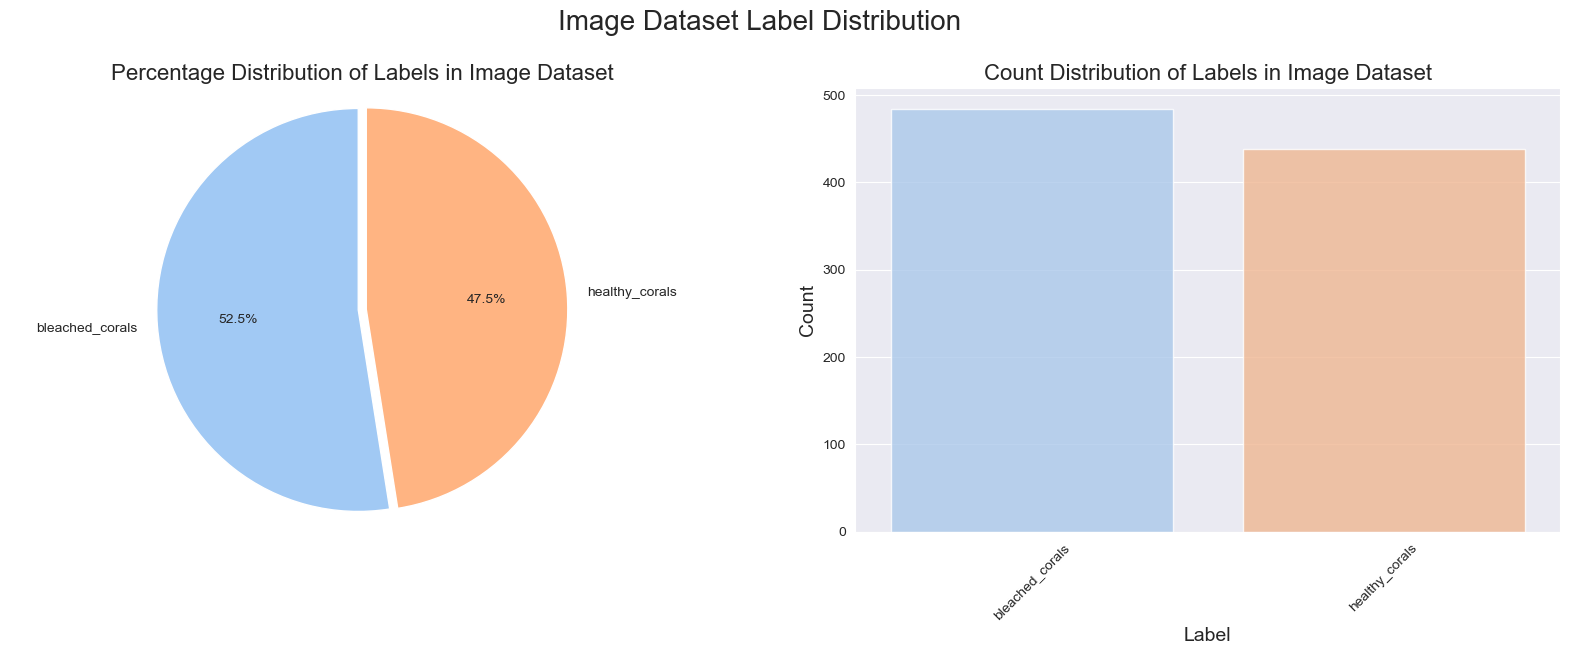

In [28]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Define the color palette for the pie chart
colors = sns.color_palette('pastel', len(label_counts))

# Plot the pie chart with percentages, colors, and separation
explode = [0.02] * len(label_counts)  # Define separation values for each pie slice
axes[0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie chart is circular
axes[0].set_title('Percentage Distribution of Labels in Image Dataset', fontsize=16)

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes[1])
axes[1].set_title('Count Distribution of Labels in Image Dataset', fontsize=16)
axes[1].set_xlabel('Label', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

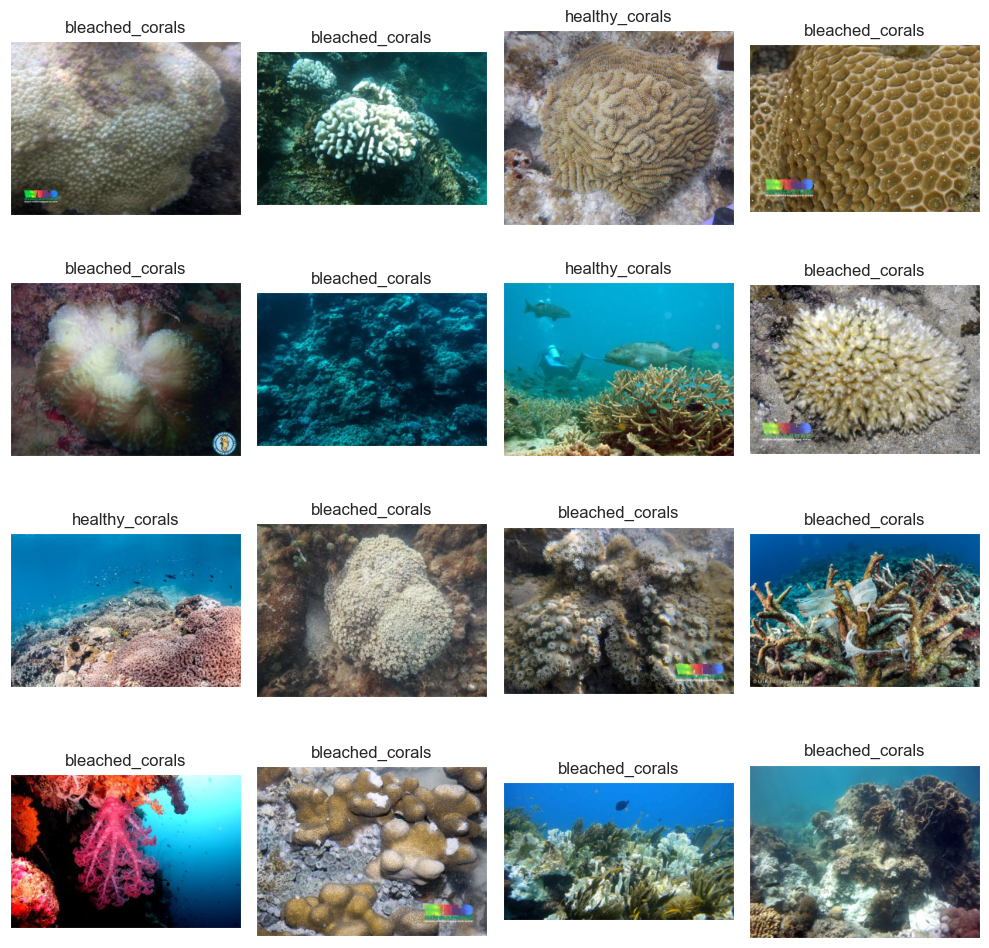

In [29]:
# Display 16 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [30]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

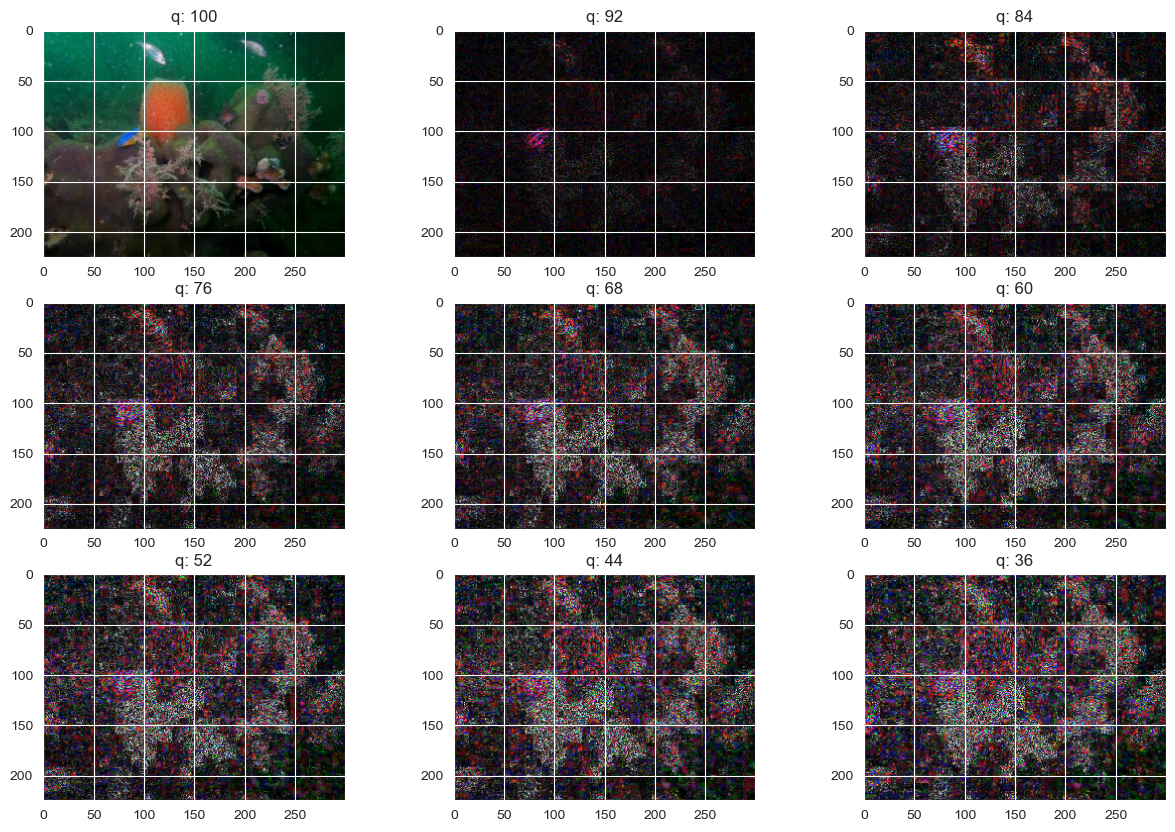

In [31]:
# View random sample from the dataset
p = random_sample('classification_corals/bleached_corals')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [32]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [33]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)


In [34]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 590 validated image filenames belonging to 2 classes.
Found 147 validated image filenames belonging to 2 classes.
Found 185 validated image filenames belonging to 2 classes.


In [35]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [36]:
# Load the pretained model
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [37]:
# Create checkpoint callback
checkpoint_path = "corals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10)

In [39]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "corals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/corals_classification/20240424-153556
Epoch 1/10
19/19 [==============================] - 688s 37s/step - loss: 0.8638 - accuracy: 0.6288 - val_loss: 4.6529 - val_accuracy: 0.4422 - lr: 0.0010
Epoch 2/10
19/19 [==============================] - 680s 36s/step - loss: 0.6810 - accuracy: 0.7220 - val_loss: 2.2392 - val_accuracy: 0.5374 - lr: 0.0010
Epoch 3/10
19/19 [==============================] - 682s 36s/step - loss: 0.6201 - accuracy: 0.7305 - val_loss: 1.7932 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 4/10
19/19 [==============================] - 697s 37s/step - loss: 0.5333 - accuracy: 0.7695 - val_loss: 1.3213 - val_accuracy: 0.5986 - lr: 0.0010
Epoch 5/10
19/19 [==============================] - 675s 36s/step - loss: 0.5631 - accuracy: 0.7763 - val_loss: 1.3266 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 6/10
19/19 [==============================] - 673s 36s/step - loss: 0.4395 - accuracy: 0.7983 - val_loss: 0.8538 - val_accuracy: 0.734

In [40]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.51791
Test Accuracy: 82.70%


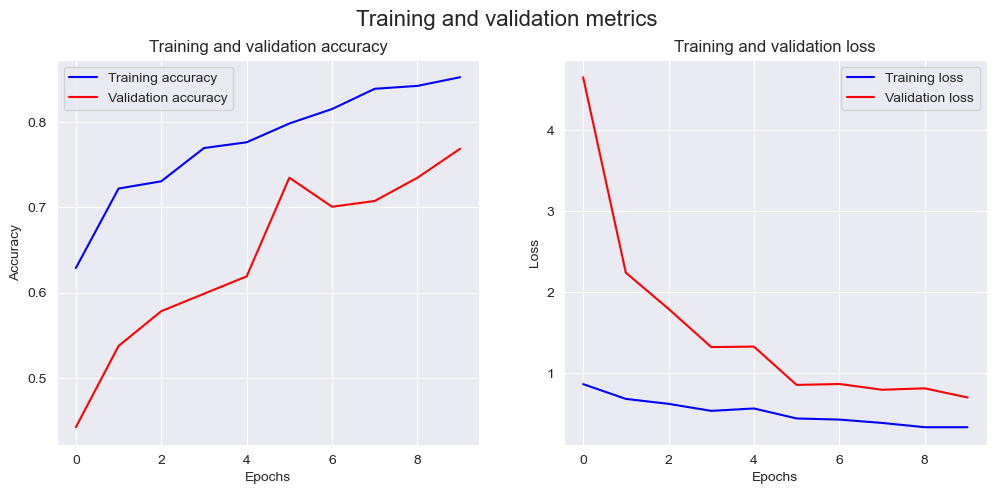

In [41]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [44]:
model.save('my_model.keras')

In [42]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

6/6 [==============================] - 175s 29s/step
The first 5 predictions: ['healthy_corals', 'bleached_corals', 'healthy_corals', 'bleached_corals', 'healthy_corals']


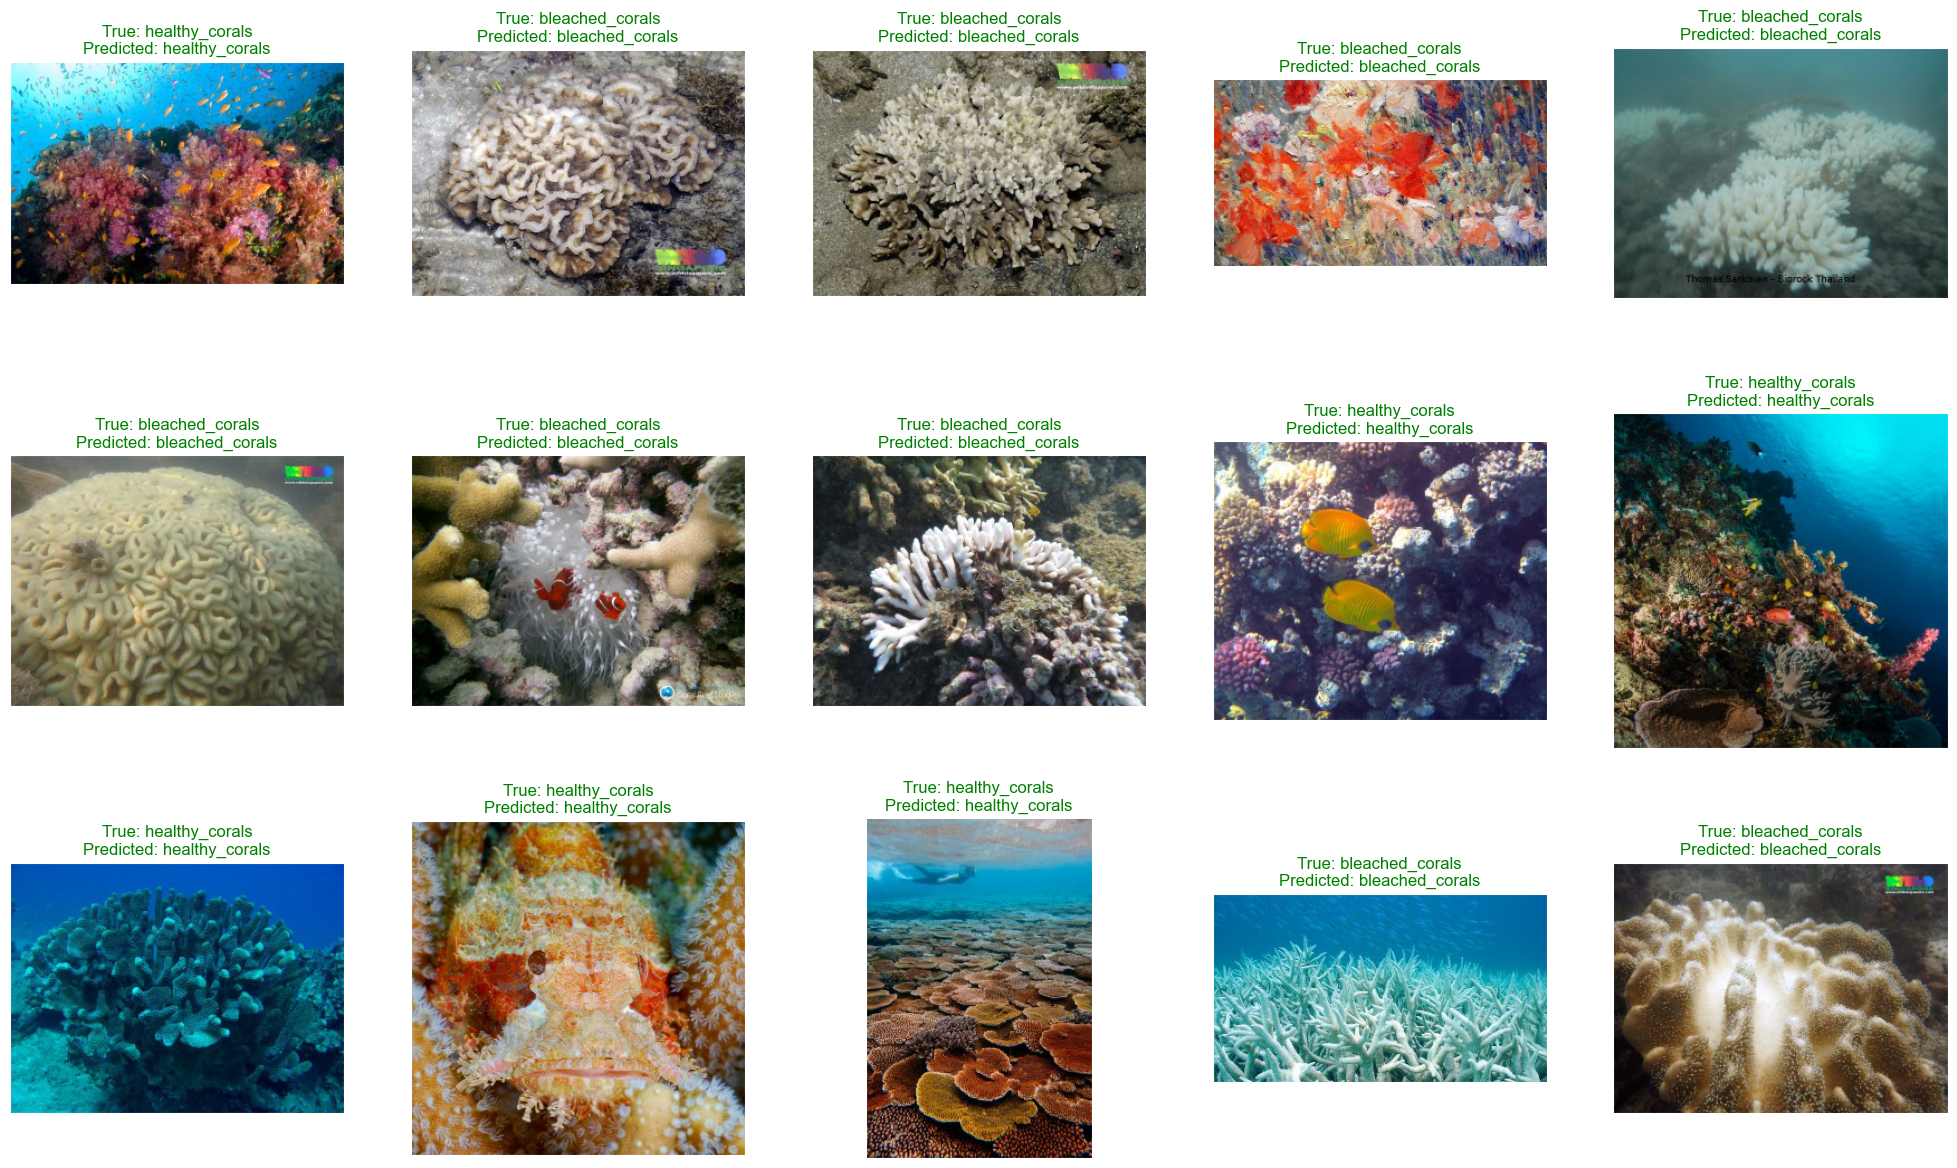

<Figure size 640x480 with 0 Axes>

In [45]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [46]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

bleached_corals       0.95      0.72      0.82       101
 healthy_corals       0.74      0.95      0.83        84

       accuracy                           0.83       185
      macro avg       0.84      0.84      0.83       185
   weighted avg       0.85      0.83      0.83       185



In [47]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
bleached_corals   0.948052  0.722772  0.820225  101.000000
healthy_corals    0.740741  0.952381  0.833333   84.000000
accuracy          0.827027  0.827027  0.827027    0.827027
macro avg         0.844396  0.837577  0.826779  185.000000
weighted avg      0.853921  0.827027  0.826177  185.000000

In [48]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

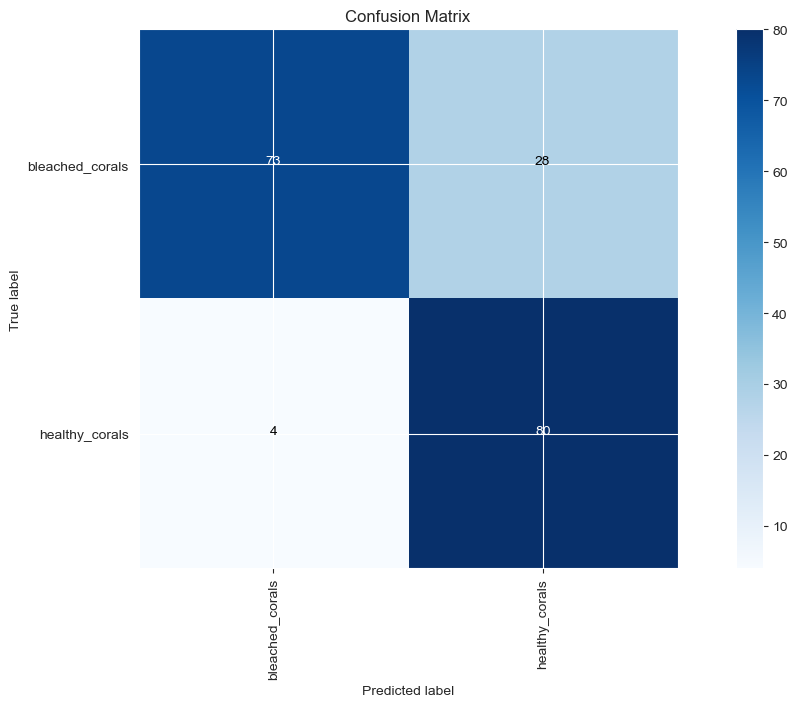

In [49]:
make_confusion_matrix(y_test, pred, list(labels.values()))